In [3]:
from __future__ import annotations

import anndata as ad
import decoupler
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn.objects as so
import session_info

import os
import sys
import logging

/ocean/projects/cis240075p/asachan/.conda/envs/decoupler/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
adata_infile = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/out_data/sc_preproc/out_files/stream_input_filtered_cells.h5ad'

# Score the cells by G0_G1 transition cell cycle

In [6]:
adata = sc.read(adata_infile)
adata

AnnData object with n_obs × n_vars = 28494 × 4142
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'leiden_filtered_cells', 'cell_type_annotation', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts

In [8]:
from pathlib import Path

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """Parse a gmt file to a decoupler pathway dataframe."""
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [9]:
G0_G1_geneset = gmt_to_decoupler("/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/GOBP_G0_TO_G1_TRANSITION.v2024.1.Hs.gmt")

In [11]:
decoupler.run_aucell(
    adata,
    G0_G1_geneset,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

In [ ]:
G0_G1_pathway = "GOBP_G0_TO_G1_TRANSITION"
adata.obs[G0_G1_pathway] = adata.obsm["aucell_estimate"][G0_G1_pathway]

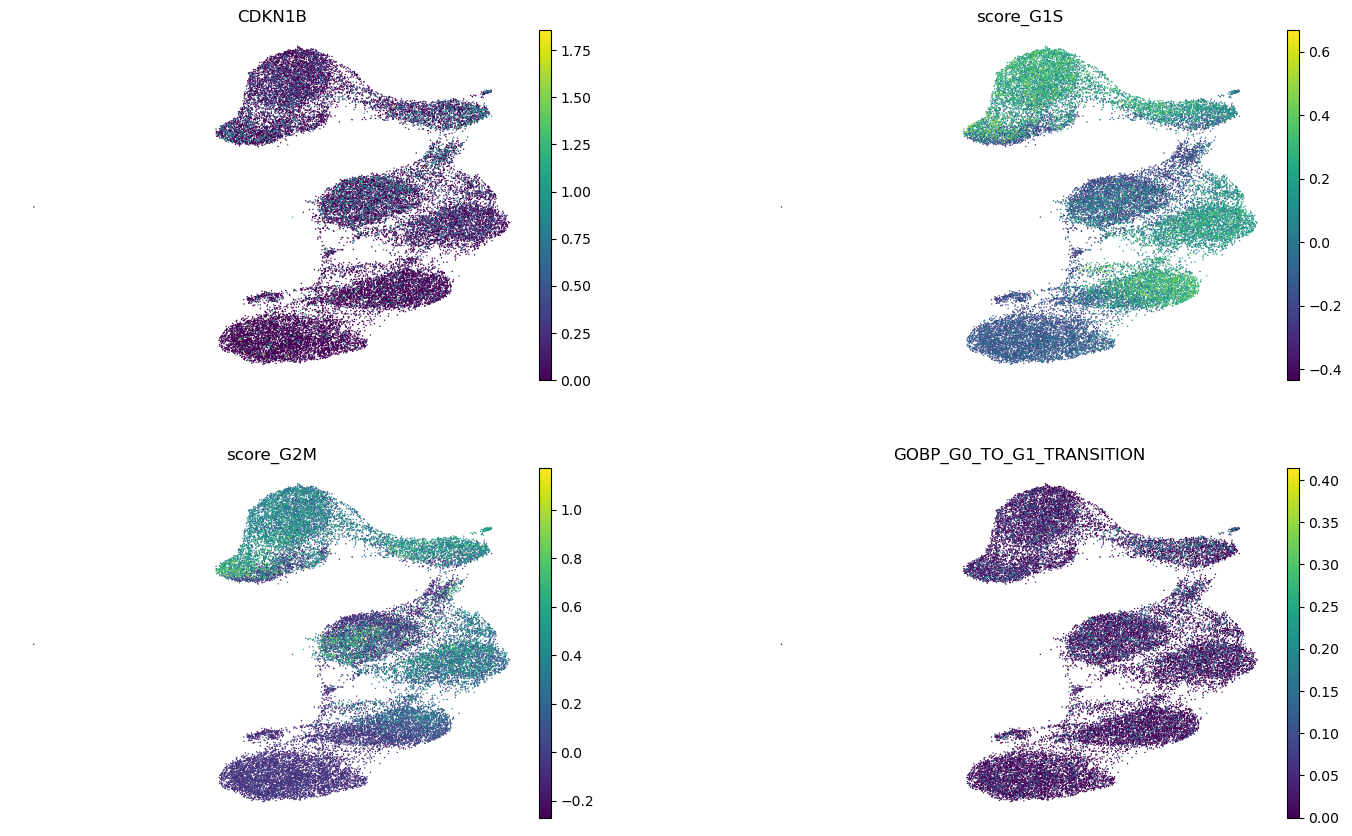

In [17]:
sc.pl.umap(
    adata,
    color=['CDKN1B', 'score_G1S', 'score_G2M'] + [G0_G1_pathway],
    frameon=False,
    ncols=2,
    wspace=0.3,
)